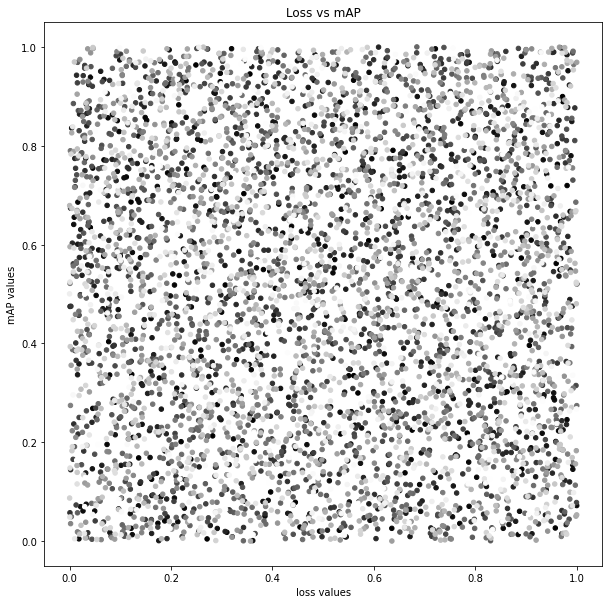

In [13]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize = [10,10])
plt.title("Loss vs mAP")
plt.xlabel("loss values")
plt.ylabel("mAP values")
plt.scatter(np.random.random(5000), np.random.random(5000), c= np.arange(5000), s = 20, cmap = 'gist_gray')


In [8]:
np.arange(20)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [12]:
np.save('prova_numpy', np.arange(20))

In [7]:
np.random.random(10)

array([0.91059272, 0.97307168, 0.98809655, 0.82373985, 0.62533919,
       0.99155505, 0.19202478, 0.33592309, 0.53154055, 0.74034454])

In [1]:
'''
Create reduced version of SSD300
'''

import argparse
import torch
from PIL import Image
from time import time
import numpy as np
import matplotlib.pyplot as plt
import os
import torchvision.transforms as transforms
from torch.utils import data
import pickle

from smithers.ml.vgg import VGG
from smithers.ml.models.aux_conv import AuxiliaryConvolutions
from smithers.ml.models.predictor import PredictionConvolutions
from smithers.ml.dataset.pascalvoc_dataset import PascalVOCDataset
from smithers.ml.models.detector import Detector, Reduced_Detector
from smithers.ml.models.utils import create_prior_boxes, save_checkpoint_objdet
from smithers.ml.netadapter import NetAdapter
from smithers.ml.utils import get_seq_model, Total_param, Total_flops

import warnings
warnings.filterwarnings("ignore")

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Learning parameters
batch_size = 8  # batch size
workers = 4  # number of workers for loading data in the DataLoader
iterations = 120000  # number of iterations to train
print_freq = 200  # print training status every __ batches
lr = 1e-4  # learning rate
decay_lr_at = [80000, 100000]  # decay learning rate after these many iterations
decay_lr_to = 0.1
# decay learning rate to this fraction of the existing learning rate
#n_classes = 6
momentum = 0.9  # momentum
weight_decay = 5e-4  # weight decay
grad_clip = None
# clip if gradients are exploding, which may happen at larger batch sizes

voc_labels = ('cat', 'dog')
'''voc_labels = ('aeroplane', 'bicycle', 'bird', 'boat',
        'bottle', 'bus', 'car', 'cat', 'chair',
        'cow', 'diningtable', 'dog', 'horse',
        'motorbike', 'person', 'pottedplant',
        'sheep', 'sofa', 'train', 'tvmonitor')'''
label_map = {k: v + 1 for v, k in enumerate(voc_labels)}
label_map['background'] = 0
n_classes = len(label_map)
print('categories:',label_map)
print('n_classes:', n_classes)

categories: {'cat': 1, 'dog': 2, 'background': 0}
n_classes: 3


In [3]:
# Data parameters
data_folder = 'VOC_dog_cat/JSONfiles' #folder with json data files
keep_difficult = True


train_dataset = PascalVOCDataset(data_folder,
                                 split='train',
                                 keep_difficult=keep_difficult)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=train_dataset.collate_fn,
    num_workers=workers,
    pin_memory=True)

epochs = iterations // (len(train_dataset) // 32)
decay_lr_at = [it // (len(train_dataset) // 32) for it in decay_lr_at]
print('Training images:', len(train_dataset))
# Load test data
test_dataset = PascalVOCDataset(data_folder,
                                split='test',
                                keep_difficult=keep_difficult)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          collate_fn=test_dataset.collate_fn,
                                          num_workers=workers,
                                          pin_memory=True)
print('Testing images:', len(test_dataset))


Training images: 240
Testing images: 60


### REDUCTION VIA AHOSVD

In [4]:
#checkpoint = 'checkpoint_ssd300.pth.tar'
init_time = time()

#base_net = VGG(classifier='ssd', init_weights=False, pretrain_weights=checkpoint)
base_net = VGG(classifier='ssd', init_weights=False)
seq_model = get_seq_model(base_net)
print(seq_model)
cutoff_idx = 7
mode_list_batch=[2, 35, 5, 5]
red_dim = 5 * 5 * 35
red_method = 'HOSVD'
inout_method = None
netadapter = NetAdapter(cutoff_idx, red_dim, red_method, inout_method)
red_model = netadapter.reduce_net(seq_model, train_dataset, None, train_loader, n_classes, device = device, mode_list_batch = mode_list_batch)
print(red_model)
base_net = red_model.premodel
aux_conv = red_model.proj_model
print(aux_conv)
#cfg_tot_ssd = [512,1024,] #channel number
#cfg_tot = [256, 50] #, 512, 256, 256, 256] #no hosvd
cfg_tot = [256, 35] #, 512, 256, 256, 256] #per hosvd
n_boxes = [4, 6]
predictor = PredictionConvolutions(n_classes, cfg_tot, n_boxes)
network = [base_net, aux_conv, predictor]

#create prior boxes custom for reduced net
#fmaps_dims = {'premodel': 38, 'projmodel': 1} #no hosvd
fmaps_dims = {'premodel': 38, 'projmodel': 5}
obj_scales = {'premodel': 0.1, 'projmodel': 0.725} #0.9
aspect_ratio = {'premodel': [1., 2., 0.5], 'projmodel': [1., 2., 3., 0.5, 0.333]}
priors_cxcy = create_prior_boxes(fmaps_dims, obj_scales, aspect_ratio)
print(f'La shape di priors_cxcy è {priors_cxcy.shape}', flush = True)
init_end = time()
print('time needed to initialize the model', init_end - init_time)

#img_path = 'VOC_cat-dog/JPEGImages/000122.jpg'
#img_path = 'VOC_cat-dog/JPEGImages/002215.jpg'
img_path = '/u/s/szanin/Smithers/smithers/ml/tutorials/VOC_dog_cat/JPEGImages/001462.jpg'


original_image = Image.open(img_path, mode='r')
original_image = original_image.convert('RGB')



Loaded base model.

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (17): Conv2d(2

### REDUCTION VIA POD

In [7]:
#checkpoint = 'checkpoint_ssd300.pth.tar'
init_time = time()

#base_net = VGG(classifier='ssd', init_weights=False, pretrain_weights=checkpoint)
base_net = VGG(classifier='ssd', init_weights=False)
seq_model = get_seq_model(base_net)
print(seq_model)
cutoff_idx = 7
red_dim = 35
red_method = 'POD'
inout_method = None
netadapter = NetAdapter(cutoff_idx, red_dim, red_method, inout_method)
red_model = netadapter.reduce_net(seq_model, train_dataset, None, train_loader, n_classes)
print(red_model)
base_net = red_model.premodel
aux_conv = red_model.proj_model
print(aux_conv)
cfg_tot = [256, 50] #, 512, 256, 256, 256]
n_boxes = [4, 6]
predictor = PredictionConvolutions(n_classes, cfg_tot, n_boxes)
network = [base_net, aux_conv, predictor]

#create prior boxes custom for reduced net
#fmaps_dims = {'premodel': 38, 'projmodel': 1} #non hosvd
fmaps_dims = {'premodel': 38, 'projmodel': 1}
obj_scales = {'premodel': 0.1, 'projmodel': 0.725} #0.9
aspect_ratio = {'premodel': [1., 2., 0.5], 'projmodel': [1., 2., 3., 0.5, 0.333]}
priors_cxcy = create_prior_boxes(fmaps_dims, obj_scales, aspect_ratio)

init_end = time()
print('time needed to initialize the model', init_end - init_time)

#img_path = 'VOC_cat-dog/JPEGImages/000122.jpg'
#img_path = 'VOC_cat-dog/JPEGImages/002215.jpg'
img_path = '/u/s/szanin/Smithers/smithers/ml/tutorials/VOC_dog_cat/JPEGImages/001462.jpg'


original_image = Image.open(img_path, mode='r')
original_image = original_image.convert('RGB')



Loaded base model.

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (17): Conv2d(2

In [5]:
check = None
epochs = 1000
start = time()
detector = Reduced_Detector(network, check, priors_cxcy, n_classes, epochs,
                    batch_size, print_freq, lr, decay_lr_at,
                    decay_lr_to, momentum, weight_decay, grad_clip,
                    train_loader, test_loader)
print(detector.model)

start = time()
check, loss_value = detector.train_detector()
end = time()
print(f'Time needed for training: {round(end-start,2)} seconds, i.e. {round((end-start)/60,1)} minutes')


start_test = time()
check = 'checkpoint_ssd300.pth.tar'
detector.eval_detector(label_map, check)
detector.detect(original_image,
                check,
                label_map,
                min_score=0.01,
                max_overlap=0.45,
                top_k=5).show()
end_test = time()
print(f'Time needed for testing: {round(end_test-start_test,2)} seconds, i.e. {round((end_test-start_test)/60,1)} minutes')


1000
[Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
), tensor_product_layer(in_dime

Evaluating: 100%|██████████| 8/8 [00:13<00:00,  1.64s/it]


{'cat': 0.2324669361114502, 'dog': 0.16028708219528198}
{'cat': 0.2324669361114502, 'dog': 0.16028708219528198}

Mean Average Precision (mAP): 0.196
Time needed to test the detector 13.790295839309692


In [6]:
#check = 'checkpoint_ssd300_red_pascalvoc.pth.tar'
#check = 'checkpoint_ssd300.pth.tar'
check = torch.load(check)
model = check['model']

rednet_storage = torch.zeros(4)
rednet_flops = torch.zeros(4)

rednet_storage[0], rednet_storage[1], rednet_storage[2], rednet_storage[3] = [
       Total_param(model[0]),
       Total_param(model[1]),
       Total_param(model[2].features_loc),
       Total_param(model[2].features_cl)]

print('SSD300 reduced-storage')
print(
      ' Pre nnz = {:.2f}, POD_model nnz={:.2f}, feature_loc nnz={:.4f}, feature_cl nnz={:.4f}'.format(
                  rednet_storage[0], rednet_storage[1],
                  rednet_storage[2], rednet_storage[3]))


SSD300 reduced-storage
 Pre nnz = 6.62, POD_model nnz=0.04, feature_loc nnz=0.1696, feature_cl nnz=0.1272


In [7]:

#check1 = 'checkpoint_ssd300_pascal_catdog_500.pth.tar'
#check1 = 'checkpoint_ssd300_catdog_500_new.pth.tar'
check1 = 'checkpoint_ssd300.pth.tar'
check1 = torch.load(check1)
model = check1['model']

rednet_storage = torch.zeros(4)
rednet_flops = torch.zeros(4)

rednet_storage[0], rednet_storage[1], rednet_storage[2], rednet_storage[3]  = [
       Total_param(model[0]),
       Total_param(model[1].features),
       Total_param(model[2].features_loc),
       Total_param(model[2].features_cl)]

rednet_vgg_storage = torch.zeros(4)
rednet_vgg_storage[0], rednet_vgg_storage[1], rednet_vgg_storage[2], rednet_vgg_storage[3],  = [
       Total_param(model[0]),
       Total_param(model[0].features),
       Total_param(model[0].avgpool),
       Total_param(model[0].classifier)]

#rednet_flops[0], rednet_flops[1], rednet_flops[2], rednet_flops[3] = [
#        Total_flops(model[0], device),
#        Total_flops(model[1], device),
#        Total_flops(model[2].features_loc, device),
#        Total_flops(model[2].features_cl, device)]


print('SSD300-storage')
print(
      ' Pre nnz = {:.2f}, aux_model nnz={:.2f}, feature_loc nnz={:.4f}, feature_cl nnz={:.4f}'.format(
                  rednet_storage[0], rednet_storage[1],
                  rednet_storage[2], rednet_storage[3]))

"""print(
      ' Pre nnz = {:.2f}, pre_vgg nnz={:.2f}, pre_avgpool nnz={:.4f}, pre_classifier nnz={:.4f}'.format(
                  rednet_vgg_storage[0], rednet_vgg_storage[1],
                  rednet_vgg_storage[2], rednet_vgg_storage[3]))"""


torch.save(detector, 'check_ssd300_red.pth')


SSD300-storage
 Pre nnz = 78.14, aux_model nnz=9.38, feature_loc nnz=2.0395, feature_cl nnz=1.5296
 Pre nnz = 78.14, pre_vgg nnz=56.13, pre_avgpool nnz=0.0000, pre_classifier nnz=22.0078
